# Dataset Description and Features
We have used handwritten notes for the dataset, mainly 100 per person. Each image will belong to one of three categories Mehdy, Umair, and Hasnain. Each image has been labeled i.e. author_img (100).jpg. Dataset when loaded in pandas will have two columns (features) mainly file_path and label.

# Imported Libraries

In [43]:
import os
import numpy as np
from PIL import Image as Img, ImageOps
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Image
import seaborn as sns


# Paths Defination

In [44]:
# Define the path to the dataset
orignal_images_path = 'orignal_images/'

# Define the path to the folder where grayscale images will be saved
grayscale_images_path = 'grayscale_images/'

# Create the projection_profiles folder if it doesn't exist
os.makedirs(grayscale_images_path, exist_ok=True)

# Define the path to the folder where padded images will be saved
padded_images_path = 'padded_images/'

# Create the padded_images folder if it doesn't exist
os.makedirs(padded_images_path, exist_ok=True)

# Define the path to the folder where the extracted 128x128 blocks will be saved
dataset_path = 'Dataset/'

# Create the extracted_blocks folder if it doesn't exist
os.makedirs(dataset_path, exist_ok=True)


# Grayscale

In [45]:
# Loop through each image file in the to be processed image folder
for file_name in os.listdir(orignal_images_path):
    # Construct the file path
    file_path = os.path.join(orignal_images_path, file_name)
    
    # Open the image using PIL
    with Img.open(file_path) as image:
        # Convert the image to grayscale
        grayscale_image = image.convert('L')
        
        # Construct the output file path in the grayscale_images folder
        output_file_path = os.path.join(grayscale_images_path, file_name)
        
        # Save the grayscale image in the grayscale_images folder
        grayscale_image.save(output_file_path)
        
        # Print a message indicating the file has been processed
        print(f'Processed {file_name} and saved as grayscale in {output_file_path}')


Processed hasnain_img (1).jpg and saved as grayscale in grayscale_images/hasnain_img (1).jpg
Processed hasnain_img (10).jpg and saved as grayscale in grayscale_images/hasnain_img (10).jpg
Processed hasnain_img (100).jpg and saved as grayscale in grayscale_images/hasnain_img (100).jpg
Processed hasnain_img (11).jpg and saved as grayscale in grayscale_images/hasnain_img (11).jpg
Processed hasnain_img (12).jpg and saved as grayscale in grayscale_images/hasnain_img (12).jpg
Processed hasnain_img (13).jpg and saved as grayscale in grayscale_images/hasnain_img (13).jpg
Processed hasnain_img (14).jpg and saved as grayscale in grayscale_images/hasnain_img (14).jpg
Processed hasnain_img (15).jpg and saved as grayscale in grayscale_images/hasnain_img (15).jpg
Processed hasnain_img (16).jpg and saved as grayscale in grayscale_images/hasnain_img (16).jpg
Processed hasnain_img (17).jpg and saved as grayscale in grayscale_images/hasnain_img (17).jpg
Processed hasnain_img (18).jpg and saved as graysc

Processed hasnain_img (9).jpg and saved as grayscale in grayscale_images/hasnain_img (9).jpg
Processed hasnain_img (90).jpg and saved as grayscale in grayscale_images/hasnain_img (90).jpg
Processed hasnain_img (91).jpg and saved as grayscale in grayscale_images/hasnain_img (91).jpg
Processed hasnain_img (92).jpg and saved as grayscale in grayscale_images/hasnain_img (92).jpg
Processed hasnain_img (93).jpg and saved as grayscale in grayscale_images/hasnain_img (93).jpg
Processed hasnain_img (94).jpg and saved as grayscale in grayscale_images/hasnain_img (94).jpg
Processed hasnain_img (95).jpg and saved as grayscale in grayscale_images/hasnain_img (95).jpg
Processed hasnain_img (96).jpg and saved as grayscale in grayscale_images/hasnain_img (96).jpg
Processed hasnain_img (97).jpg and saved as grayscale in grayscale_images/hasnain_img (97).jpg
Processed hasnain_img (98).jpg and saved as grayscale in grayscale_images/hasnain_img (98).jpg
Processed hasnain_img (99).jpg and saved as grayscal

Processed mehdy_img (80).jpg and saved as grayscale in grayscale_images/mehdy_img (80).jpg
Processed mehdy_img (81).jpg and saved as grayscale in grayscale_images/mehdy_img (81).jpg
Processed mehdy_img (82).jpg and saved as grayscale in grayscale_images/mehdy_img (82).jpg
Processed mehdy_img (83).jpg and saved as grayscale in grayscale_images/mehdy_img (83).jpg
Processed mehdy_img (84).jpg and saved as grayscale in grayscale_images/mehdy_img (84).jpg
Processed mehdy_img (85).jpg and saved as grayscale in grayscale_images/mehdy_img (85).jpg
Processed mehdy_img (86).jpg and saved as grayscale in grayscale_images/mehdy_img (86).jpg
Processed mehdy_img (87).jpg and saved as grayscale in grayscale_images/mehdy_img (87).jpg
Processed mehdy_img (88).jpg and saved as grayscale in grayscale_images/mehdy_img (88).jpg
Processed mehdy_img (89).jpg and saved as grayscale in grayscale_images/mehdy_img (89).jpg
Processed mehdy_img (9).jpg and saved as grayscale in grayscale_images/mehdy_img (9).jpg
P

Processed umair_img (71).jpg and saved as grayscale in grayscale_images/umair_img (71).jpg
Processed umair_img (72).jpg and saved as grayscale in grayscale_images/umair_img (72).jpg
Processed umair_img (73).jpg and saved as grayscale in grayscale_images/umair_img (73).jpg
Processed umair_img (74).jpg and saved as grayscale in grayscale_images/umair_img (74).jpg
Processed umair_img (75).jpg and saved as grayscale in grayscale_images/umair_img (75).jpg
Processed umair_img (76).jpg and saved as grayscale in grayscale_images/umair_img (76).jpg
Processed umair_img (77).jpg and saved as grayscale in grayscale_images/umair_img (77).jpg
Processed umair_img (78).jpg and saved as grayscale in grayscale_images/umair_img (78).jpg
Processed umair_img (79).jpg and saved as grayscale in grayscale_images/umair_img (79).jpg
Processed umair_img (8).jpg and saved as grayscale in grayscale_images/umair_img (8).jpg
Processed umair_img (80).jpg and saved as grayscale in grayscale_images/umair_img (80).jpg
P

# Image Padding

In [46]:
# Function to pad grayscale images
def pad_image(file_path, output_path, target_size=(550, 720)):
    # Open the grayscale image
    with Img.open(file_path) as grayscale_image:
        # Perform padding to the target size
        # Using ImageOps.pad to pad the image to the target size while maintaining the aspect ratio
        padded_image = ImageOps.pad(grayscale_image, target_size, method=0, centering=(0.5, 0.5))
        
        # Construct the output file path in the padded_images folder
        output_file_path = os.path.join(output_path, os.path.basename(file_path))
        
        # Save the padded image
        padded_image.save(output_file_path)
        
        # Print a message indicating the file has been processed
        print(f'Padded and saved {file_name} to {output_file_path}')
        
        return padded_image

# Loop through each grayscale image file in the folder
for file_name in os.listdir(grayscale_images_path):
    # Construct the file path
    file_path = os.path.join(grayscale_images_path, file_name)
    
    # Pad the grayscale image
    pad_image(file_path, padded_images_path)


Padded and saved hasnain_img (1).jpg to padded_images/hasnain_img (1).jpg
Padded and saved hasnain_img (10).jpg to padded_images/hasnain_img (10).jpg
Padded and saved hasnain_img (100).jpg to padded_images/hasnain_img (100).jpg
Padded and saved hasnain_img (11).jpg to padded_images/hasnain_img (11).jpg
Padded and saved hasnain_img (12).jpg to padded_images/hasnain_img (12).jpg
Padded and saved hasnain_img (13).jpg to padded_images/hasnain_img (13).jpg
Padded and saved hasnain_img (14).jpg to padded_images/hasnain_img (14).jpg
Padded and saved hasnain_img (15).jpg to padded_images/hasnain_img (15).jpg
Padded and saved hasnain_img (16).jpg to padded_images/hasnain_img (16).jpg
Padded and saved hasnain_img (17).jpg to padded_images/hasnain_img (17).jpg
Padded and saved hasnain_img (18).jpg to padded_images/hasnain_img (18).jpg
Padded and saved hasnain_img (19).jpg to padded_images/hasnain_img (19).jpg
Padded and saved hasnain_img (2).jpg to padded_images/hasnain_img (2).jpg
Padded and sav

Padded and saved mehdy_img (21).jpg to padded_images/mehdy_img (21).jpg
Padded and saved mehdy_img (22).jpg to padded_images/mehdy_img (22).jpg
Padded and saved mehdy_img (23).jpg to padded_images/mehdy_img (23).jpg
Padded and saved mehdy_img (24).jpg to padded_images/mehdy_img (24).jpg
Padded and saved mehdy_img (25).jpg to padded_images/mehdy_img (25).jpg
Padded and saved mehdy_img (26).jpg to padded_images/mehdy_img (26).jpg
Padded and saved mehdy_img (27).jpg to padded_images/mehdy_img (27).jpg
Padded and saved mehdy_img (28).jpg to padded_images/mehdy_img (28).jpg
Padded and saved mehdy_img (29).jpg to padded_images/mehdy_img (29).jpg
Padded and saved mehdy_img (3).jpg to padded_images/mehdy_img (3).jpg
Padded and saved mehdy_img (30).jpg to padded_images/mehdy_img (30).jpg
Padded and saved mehdy_img (31).jpg to padded_images/mehdy_img (31).jpg
Padded and saved mehdy_img (32).jpg to padded_images/mehdy_img (32).jpg
Padded and saved mehdy_img (33).jpg to padded_images/mehdy_img (33

Padded and saved umair_img (36).jpg to padded_images/umair_img (36).jpg
Padded and saved umair_img (37).jpg to padded_images/umair_img (37).jpg
Padded and saved umair_img (38).jpg to padded_images/umair_img (38).jpg
Padded and saved umair_img (39).jpg to padded_images/umair_img (39).jpg
Padded and saved umair_img (4).jpg to padded_images/umair_img (4).jpg
Padded and saved umair_img (40).jpg to padded_images/umair_img (40).jpg
Padded and saved umair_img (41).jpg to padded_images/umair_img (41).jpg
Padded and saved umair_img (42).jpg to padded_images/umair_img (42).jpg
Padded and saved umair_img (43).jpg to padded_images/umair_img (43).jpg
Padded and saved umair_img (44).jpg to padded_images/umair_img (44).jpg
Padded and saved umair_img (45).jpg to padded_images/umair_img (45).jpg
Padded and saved umair_img (46).jpg to padded_images/umair_img (46).jpg
Padded and saved umair_img (47).jpg to padded_images/umair_img (47).jpg
Padded and saved umair_img (48).jpg to padded_images/umair_img (48

# Center blocks 

In [48]:
# Function to extract 192x192 blocks from the center of padded images
def extract_center_block(file_path, output_path, block_size=192):
    # Open the padded grayscale image
    with Img.open(file_path) as padded_image:
        # Get the original width and height of the image
        width, height = padded_image.size
        
        # Calculate the top left coordinates of the center block
        top_left_x = (width - block_size) // 2
        top_left_y = (height - block_size) // 2
        
        # Extract a 128x128 block from the center of the image
        center_block = padded_image.crop((top_left_x, top_left_y, top_left_x + block_size, top_left_y + block_size))
        
        # Construct the output file path in the extracted_blocks folder
        output_file_path = os.path.join(output_path, os.path.basename(file_path))
        
        # Save the extracted block
        center_block.save(output_file_path)
        
        # Print a message indicating the file has been processed
        print(f'Extracted center block and saved {file_name} to {output_file_path}')
        
        return center_block

# Loop through each padded image file in the folder
for file_name in os.listdir(padded_images_path):
    # Construct the file path
    file_path = os.path.join(padded_images_path, file_name)
    
    # Extract 192x192 blocks from the center of the padded image
    extract_center_block(file_path, dataset_path)


Extracted center block and saved hasnain_img (1).jpg to Dataset/hasnain_img (1).jpg
Extracted center block and saved hasnain_img (10).jpg to Dataset/hasnain_img (10).jpg
Extracted center block and saved hasnain_img (100).jpg to Dataset/hasnain_img (100).jpg
Extracted center block and saved hasnain_img (11).jpg to Dataset/hasnain_img (11).jpg
Extracted center block and saved hasnain_img (12).jpg to Dataset/hasnain_img (12).jpg
Extracted center block and saved hasnain_img (13).jpg to Dataset/hasnain_img (13).jpg
Extracted center block and saved hasnain_img (14).jpg to Dataset/hasnain_img (14).jpg
Extracted center block and saved hasnain_img (15).jpg to Dataset/hasnain_img (15).jpg
Extracted center block and saved hasnain_img (16).jpg to Dataset/hasnain_img (16).jpg
Extracted center block and saved hasnain_img (17).jpg to Dataset/hasnain_img (17).jpg
Extracted center block and saved hasnain_img (18).jpg to Dataset/hasnain_img (18).jpg
Extracted center block and saved hasnain_img (19).jpg 

Extracted center block and saved mehdy_img (13).jpg to Dataset/mehdy_img (13).jpg
Extracted center block and saved mehdy_img (14).jpg to Dataset/mehdy_img (14).jpg
Extracted center block and saved mehdy_img (15).jpg to Dataset/mehdy_img (15).jpg
Extracted center block and saved mehdy_img (16).jpg to Dataset/mehdy_img (16).jpg
Extracted center block and saved mehdy_img (17).jpg to Dataset/mehdy_img (17).jpg
Extracted center block and saved mehdy_img (18).jpg to Dataset/mehdy_img (18).jpg
Extracted center block and saved mehdy_img (19).jpg to Dataset/mehdy_img (19).jpg
Extracted center block and saved mehdy_img (2).jpg to Dataset/mehdy_img (2).jpg
Extracted center block and saved mehdy_img (20).jpg to Dataset/mehdy_img (20).jpg
Extracted center block and saved mehdy_img (21).jpg to Dataset/mehdy_img (21).jpg
Extracted center block and saved mehdy_img (22).jpg to Dataset/mehdy_img (22).jpg
Extracted center block and saved mehdy_img (23).jpg to Dataset/mehdy_img (23).jpg
Extracted center b

Extracted center block and saved umair_img (17).jpg to Dataset/umair_img (17).jpg
Extracted center block and saved umair_img (18).jpg to Dataset/umair_img (18).jpg
Extracted center block and saved umair_img (19).jpg to Dataset/umair_img (19).jpg
Extracted center block and saved umair_img (2).jpg to Dataset/umair_img (2).jpg
Extracted center block and saved umair_img (20).jpg to Dataset/umair_img (20).jpg
Extracted center block and saved umair_img (21).jpg to Dataset/umair_img (21).jpg
Extracted center block and saved umair_img (22).jpg to Dataset/umair_img (22).jpg
Extracted center block and saved umair_img (23).jpg to Dataset/umair_img (23).jpg
Extracted center block and saved umair_img (24).jpg to Dataset/umair_img (24).jpg
Extracted center block and saved umair_img (25).jpg to Dataset/umair_img (25).jpg
Extracted center block and saved umair_img (26).jpg to Dataset/umair_img (26).jpg
Extracted center block and saved umair_img (27).jpg to Dataset/umair_img (27).jpg
Extracted center b

# Preprocessing with Pandas

In [55]:
# Initialize an empty list to store data about each image
data = []

# Loop through each image file in the dataset folder
for file_name in os.listdir(dataset_path):
    # Check if the file has an image extension (e.g., .jpg,etc.)
    if file_name.endswith(('.jpg')):
        # Construct the full file path
        file_path = os.path.join(dataset_path, file_name)
        
        # Extract the label from the file name
        label = file_name.split('_')[0]
        
        # Append the file path and label to the data list
        data.append({'file_path': file_path, 'label': label})

# Create a pandas DataFrame from the data list
df = pd.DataFrame(data)

# Display the DataFrame
print("\nThe Dimensionality: \n",df.shape)

# Get the shape of the DataFrame
rows, columns = df.shape

# Print the shape
print(f"The DataFrame has {rows} rows and {columns} columns.")

# Obtain descriptive statistics for numerical features in the DataFrame
summary_statistics = df.describe()

# Print the summary statistics
print("\nThe Descriptive statistics: \n",summary_statistics)

print("\nData Type: \n",df.dtypes)

# Convert object columns to numeric types where possible
df_numeric = df.apply(pd.to_numeric, errors='coerce')

# Calculate IQR for numerical columns
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

# Define the acceptable range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers in the duplicate DataFrame
outliers = ((df_numeric < lower_bound) | (df_numeric > upper_bound)).any(axis=1)

# Print outliers from the original DataFrame
print("\nOutliers using IQR method:\n")
print(df[outliers])



The Dimensionality: 
 (302, 2)
The DataFrame has 302 rows and 2 columns.

The Descriptive statistics: 
                           file_path  label
count                           302    302
unique                          302      3
top     Dataset/hasnain_img (1).jpg  mehdy
freq                              1    101

Data Type: 
 file_path    object
label        object
dtype: object

Outliers using IQR method:

Empty DataFrame
Columns: [file_path, label]
Index: []


# Outliers and dtype conversion: 
In the above cell, we have tried to find the ouliers by converting the object type column into numeric and from the results we can deduce that there are no outliers in our dataset since the result of iqr method show empty dataframe. Since our dataset is purely categorial we do not need numeric columns and our dataset comprises on the label and file_path of the dataset which we created ourselves from the scratch, hence we do not have any undesireable missing values.

# Display image from dataset

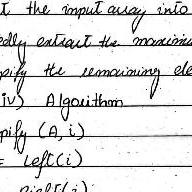

Label: hasnain


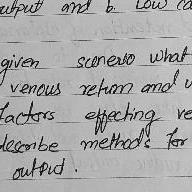

Label: mehdy


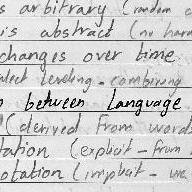

Label: umair


In [56]:
# Function to display an image from a DataFrame row
def display_image(row):
    # Get the file path from the DataFrame row
    file_path = row['file_path']
    
    # Display the image
    display(Image(filename=file_path, width=192, height=192))
    
    # Print the label of the image
    print(f'Label: {row["label"]}')

# image in the DataFrame
display_image(df.iloc[52])
display_image(df.iloc[101])
display_image(df.iloc[202])


# Data Visualization with Matplotlib

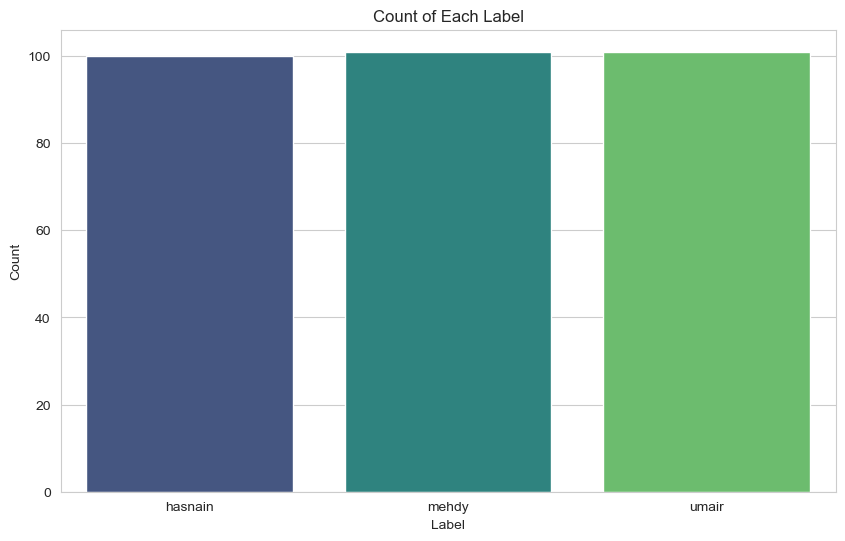

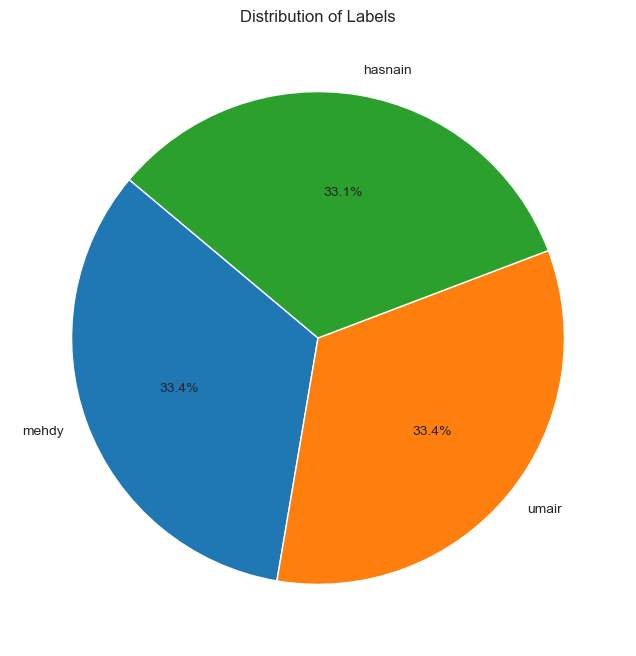

In [59]:
# Set the plot style
sns.set_style('whitegrid')

# Create the bar chart (categorical graph)
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', palette='viridis')

# Set the title and labels
plt.title('Count of Each Label')
plt.xlabel('Label')
plt.ylabel('Count')

# Show the plot
plt.show()

# Get the count of each label
label_counts = df['label'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)

# Set the title
plt.title('Distribution of Labels')

# Show the plot
plt.show()


# Methadology
For our project, we have started by collecting a dataset comprising handwriting samples from three distinct categories: Umair, Hasnain, and Mehdy. These samples will encompass a variety of writing styles and variations to ensure comprehensive coverage. Subsequently, we will preprocess the data by normalizing or resizing the images, applying grayscale filtering to standardize the representation, and removing any noise or artifacts that may affect model performance. To ensure uniformity in input dimensions, we will pad the images and resize them to a standardized size, such as 192x192 pixels. Following data preprocessing, we will extract features using grey-scale filter (along with padding, resizing etc), which have proven effective in similar applications. Then, we will train a K-Nearest Neighbors (K-NN) classifier on the extracted features, tuning hyperparameters for optimal performance. Model evaluation will involve assessing performance metrics on a testing set to ensure robustness and generalization